### Food Cost Predictive Modeling: Prophet

Overview:
- Model Selection
    1. This predictive modeling will use Facebook Prophet to forecast product prices
    2. Prophet was selected as it is compatible with multiple regressors (e.g. holidays, company sale promotions) when predicting its target variable.
- Prepare data for making predictions
    1. Define time-series column as 'ds' and target columns (price) as 'y' so that Prophet will recognize the correct values
    2. Define training dataset as records from 1995 - 2020
    3. Define validation dataset as records from 2021 - 2022
- Perform predictions using Prophet
    1. Create metric for measuring the accuracy of each model (WMAPE)
    2. Define seasonality parameters
    3. Iterate through unique products contained in the training dataset to make predictions
- Visualize predictions
    1. Plot predicted and actual values over time
    2. Compare predicted values to validation values using WMAPE to generate overall percent error for each product's prediction.

#### Preparing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stats_can import StatsCan
sc = StatsCan(data_folder='../data_sources/raw_data/')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import data
national_df = pd.read_csv('../data_sources/clean_data/national_MRA_clean.csv')

In [4]:
# rename columns to contain the 'ds' and 'y' column names required by Prophet
national_df_renamed = national_df.rename(columns={'date':'ds', 'price':'y'})

national_df_renamed

,ds,location,vectorid,y,product,unit_quantity,unit,category
0,1995-01-01,Canada,v735165,10.17,Round steak,1.0,kilogram,Protein
1,1995-01-01,Canada,v735176,11.25,Sirloin steak,1.0,kilogram,Protein
2,1995-01-01,Canada,v735187,12.08,Prime rib roast,1.0,kilogram,Protein
3,1995-01-01,Canada,v735198,7.23,Blade roast,1.0,kilogram,Protein
4,1995-01-01,Canada,v735209,7.12,Stewing beef,1.0,kilogram,Protein
...,...,...,...,...,...,...,...,...
15649,2022-02-01,Canada,v735202,7.10,"Coffee, instant",200.0,grams,Beverages
15650,2022-02-01,Canada,v735203,4.49,Tea,72.0,bags,Beverages
15651,2022-02-01,Canada,v735204,4.45,Cooking or salad oil,1.0,litre,Oils
15652,2022-02-01,Canada,v735205,1.28,"Soup, canned",284.0,millilitres,Other_foods


In [5]:
# cast 'ds' column to datetime
national_df_renamed['ds'] = pd.to_datetime(national_df_renamed['ds'])
national_df_renamed.dtypes

ds               datetime64[ns]
location                 object
vectorid                 object
y                       float64
product                  object
unit_quantity           float64
unit                     object
category                 object
dtype: object

In [6]:
# define training and validation sets
# threshold between splits will be 2016 in order to make predictions for years prior to COVID-19
train = national_df_renamed.loc[national_df_renamed['ds'].dt.year <= 2016]
valid = national_df_renamed.loc[(national_df_renamed['ds'].dt.year > 2016)]

In [7]:
# check first and last dates in training data
train

,ds,location,vectorid,y,product,unit_quantity,unit,category
0,1995-01-01,Canada,v735165,10.17,Round steak,1.00,kilogram,Protein
1,1995-01-01,Canada,v735176,11.25,Sirloin steak,1.00,kilogram,Protein
2,1995-01-01,Canada,v735187,12.08,Prime rib roast,1.00,kilogram,Protein
3,1995-01-01,Canada,v735198,7.23,Blade roast,1.00,kilogram,Protein
4,1995-01-01,Canada,v735209,7.12,Stewing beef,1.00,kilogram,Protein
...,...,...,...,...,...,...,...,...
12851,2016-12-01,Canada,v735205,1.12,"Soup, canned",284.00,millilitres,Other_foods
12852,2016-12-01,Canada,v735207,3.31,Peanut butter,500.00,grams,Protein
12853,2016-12-01,Canada,v735208,1.89,Fruit flavoured crystals,2.25,litres,Beverages
12854,2016-12-01,Canada,v735210,2.03,"Soft drinks, cola type",2.00,litres,Beverages


In [8]:
# check dtypes of dtraining data
train.dtypes

ds               datetime64[ns]
location                 object
vectorid                 object
y                       float64
product                  object
unit_quantity           float64
unit                     object
category                 object
dtype: object

In [9]:
# check first and last dates in validation data
valid

,ds,location,vectorid,y,product,unit_quantity,unit,category
12856,2017-01-01,Canada,v735165,17.67,Round steak,1.0,kilogram,Protein
12857,2017-01-01,Canada,v735176,22.09,Sirloin steak,1.0,kilogram,Protein
12858,2017-01-01,Canada,v735187,31.32,Prime rib roast,1.0,kilogram,Protein
12859,2017-01-01,Canada,v735198,15.91,Blade roast,1.0,kilogram,Protein
12860,2017-01-01,Canada,v735209,15.22,Stewing beef,1.0,kilogram,Protein
...,...,...,...,...,...,...,...,...
15649,2022-02-01,Canada,v735202,7.10,"Coffee, instant",200.0,grams,Beverages
15650,2022-02-01,Canada,v735203,4.49,Tea,72.0,bags,Beverages
15651,2022-02-01,Canada,v735204,4.45,Cooking or salad oil,1.0,litre,Oils
15652,2022-02-01,Canada,v735205,1.28,"Soup, canned",284.0,millilitres,Other_foods


In [10]:
# check dtypes of validation data
valid.dtypes

ds               datetime64[ns]
location                 object
vectorid                 object
y                       float64
product                  object
unit_quantity           float64
unit                     object
category                 object
dtype: object

#### Make Predictions

Prophet terminology:
- ds: date used for predictions
- y: predicted value
- yhat: midpoint of prediction interval (the most likely value for the forecast)
- yhat_lower: lower bound of the prediction interval
- yhat_upper: upper bound of the prediction interval

Resource used to carry out this modeling step: https://forecastegy.com/posts/multiple-time-series-forecasting-with-prophet-in-python/ 

In [11]:
# create a means to measure the model's performance

# use WMAPE (weighted mean absolute percentage error), where the absolutes of the actual values are the weights
def wmape(y_true, y_pred):
    # suppress division by zero error
    np.seterr(divide='ignore', invalid='ignore')
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [ ]:
# # Code version 1: Predict prices based on an initial training dataset, then compare predicted and validation data

# # import Prophet and train it on time series data for each product
# from prophet import Prophet 

# # create a list to store each prediction
# p = list()

# # iterate through unique product values to create a prediction for each product
# for product in train['product'].unique():
#     print('product:', product)
#     # create datasets that contain only the rows from the original training and validation datasets that correspond with the current product being forecasted
#     train_ = train.loc[train['product'] == product]
#     valid_ = valid.loc[valid['product'] == product]

#     # create a Prophet object m with seasonality parameters
#     m = Prophet(seasonality_mode='additive', yearly_seasonality=True)
#     # train the model with the product-specific training data
#     m.fit(train_)

#     # create a new dataframe that will contain the dates for the next 24 months after the end of the {train_} dataset
#     future = m.make_future_dataframe(periods = 24, freq= 'M', include_history=False)
#     # create new columns containing only month and year values to permit accurate joins
#     #   values of 'ds' in {future} are the last day of the month
#     #   values of 'ds' in the {valid_} dataframe are the first day of the month
#     future['yyyy_mm'] = pd.to_datetime(future['ds']).dt.strftime('%Y-%m')
#     valid_['yyyy_mm'] = pd.to_datetime(valid_['ds']).dt.strftime('%Y-%m')
#     # drop old 'ds' columns
#     future.drop(columns=['ds'], inplace=True)
#     valid_.drop(columns=['ds'], inplace=True)
#     # rename new 'yyyy_mm' columns to 'ds'
#     future.rename(columns={'yyyy_mm':'ds'}, inplace=True)
#     valid_.rename(columns={'yyyy_mm':'ds'}, inplace=True)
#     # merge future data with valid_ data
#     future = future.merge(valid_[['ds','product', 'y']], on=['ds'], how='left')
    
#     # create a dataframe to contain the predicted values for each date in the {future} dataframe
#     forecast = m.predict(future)
#     # add a 'product' column to the {forecast} dataframe containing predicted values
#     # this step is essential for distinguishing between predictions, since the final dataframe {p} will contain predictions for all products
#     forecast['product'] = product
#     # append the product prediction to the list of stored predictions
#     p.append(forecast[['ds', 'yhat', 'product', 'yhat_upper', 'yhat_lower']])

# # concatenate all dataframes within the list 
# print('concatenating all product dataframes...')
# p = pd.concat(p, ignore_index=True)
# # clip values in the 'yhat' column to be greater than or equal to 0 so that no negative values are included for the dataset
# p['yhat'] = p['yhat'].clip(lower=0)
# # create new 'yyyy_mm' column for {valid} dataframe
# valid['yyyy_mm'] = pd.to_datetime(valid['ds']).dt.strftime('%Y-%m')
# # drop old 'ds' column
# valid.drop(columns=['ds'], inplace=True)
# # rename new 'yyyy_mm' column to 'ds'
# valid.rename(columns={'yyyy_mm':'ds'}, inplace=True)
# # convert {valid} 'ds' column to datetime
# valid['ds'] = pd.to_datetime(valid['ds'])
# # merge prediction {p} dataframe with validation {valid} dataframe to compare values 
# p = p.merge(valid, on=['ds', 'product'], how='left')
# # calculate performance
# wmape(p['y'], p['yhat'])

In [ ]:
# # Code version 2: incorporating cross-validation & rolling prediction window

# # import Prophet and train it on time series data for each product
# from prophet import Prophet 
# from prophet.diagnostics import cross_validation

# # create a list to store each prediction
# p = list()

# # iterate through unique product values to create a prediction for each product
# for product in train['product'].unique()[0:5]:
#     print('product:', product)
#     # create datasets that contain only the rows from the original training and validation datasets that correspond with the current product being forecasted
#     train_ = train.loc[train['product'] == product]
#     valid_ = valid.loc[valid['product'] == product]

#     # create a Prophet object m with seasonality parameters
#     m = Prophet(seasonality_mode='additive', yearly_seasonality=True)
#     # train the model with the product-specific training data
#     m.fit(train_)
#     # create a cross validations dataframe
#     df_cv = cross_validation(model=m, initial='1825 days', period='91 days', horizon = '182 days')
#     print(df_cv.head())

#     # create a new dataframe that will contain the dates for the next 24 months after the end of the {train_} dataset
#     future = m.make_future_dataframe(periods = 3, freq= 'M', include_history=False)
#     # create new columns containing only month and year values to permit accurate joins
#     #   values of 'ds' in {future} are the last day of the month
#     #   values of 'ds' in the {valid_} dataframe are the first day of the month
#     future['yyyy_mm'] = pd.to_datetime(future['ds']).dt.strftime('%Y-%m')
#     valid_['yyyy_mm'] = pd.to_datetime(valid_['ds']).dt.strftime('%Y-%m')
#     # drop old 'ds' columns
#     future.drop(columns=['ds'], inplace=True)
#     valid_.drop(columns=['ds'], inplace=True)
#     # rename new 'yyyy_mm' columns to 'ds'
#     future.rename(columns={'yyyy_mm':'ds'}, inplace=True)
#     valid_.rename(columns={'yyyy_mm':'ds'}, inplace=True)
#     # merge future data with valid_ data
#     future = future.merge(valid_[['ds','product', 'y']], on=['ds'], how='left')
    
#     # create a dataframe to contain the predicted values for each date in the {future} dataframe
#     forecast = m.predict(future)
#     # add a 'product' column to the {forecast} dataframe containing predicted values
#     # this step is essential for distinguishing between predictions, since the final dataframe {p} will contain predictions for all products
#     forecast['product'] = product
#     # append the product prediction to the list of stored predictions
#     p.append(forecast[['ds', 'yhat', 'product', 'yhat_upper', 'yhat_lower']])


# # concatenate all dataframes within the list 
# print('concatenating all product dataframes...')
# p = pd.concat(p, ignore_index=True)
# # clip values in the 'yhat' column to be greater than or equal to 0 so that no negative values are included for the dataset
# p['yhat'] = p['yhat'].clip(lower=0)
# # create new 'yyyy_mm' column for {valid} dataframe
# valid['yyyy_mm'] = pd.to_datetime(valid['ds']).dt.strftime('%Y-%m')
# # drop old 'ds' column
# valid.drop(columns=['ds'], inplace=True)
# # rename new 'yyyy_mm' column to 'ds'
# valid.rename(columns={'yyyy_mm':'ds'}, inplace=True)
# # convert {valid} 'ds' column to datetime
# valid['ds'] = pd.to_datetime(valid['ds'])
# # merge prediction {p} dataframe with validation {valid} dataframe to compare values 
# p = p.merge(valid, on=['ds', 'product'], how='left')
# # calculate performance
# wmape(p['y'], p['yhat'])

In [12]:
# Code version 3: investigate cross-validation dataframes in more detail. Using a rolling forecast eliminates the need for {train} and {valid} dataframes. 

# import Prophet and train it on time series data for each product
from prophet import Prophet 
from prophet.diagnostics import cross_validation

# create a list to store each prediction
final = list()

# iterate through unique product values to create a prediction for each product
for product in national_df_renamed['product'].unique()[0:5]:
    print('product:', product)
    
    # create a subset of the training data specific to each product
    national_df_renamed_ = national_df_renamed.loc[national_df_renamed['product'] == product]

    # create a Prophet object m with seasonality parameters
    m = Prophet(seasonality_mode='additive', yearly_seasonality=True)
    # train the model with the product-specific data
    m.fit(national_df_renamed_)

    # create a cross validations dataframe to hold the predicted values as well as the actual values
    df_cv = cross_validation(m, initial='1825 days', period='91 days', horizon = '182 days')
    print(df_cv.head())
    
    # add a 'product' column to the {df_cv} dataframe containing predicted and actual values
    # this step is essential for distinguishing between predictions, since the final dataframe {p} will contain predictions for all products
    df_cv['product'] = product
    # append the product prediction to the list of stored predictions
    final.append(df_cv)


# concatenate all dataframes within the list 
print('concatenating all product dataframes...')
final = pd.concat(final, ignore_index=True)
# clip values in the 'yhat' column to be greater than or equal to 0 so that no negative values are included for the dataset
final['yhat'] = final['yhat'].clip(lower=0)
# print first values of the final dataframe
print(final.head())


16:27:29 - cmdstanpy - INFO - Chain [1] start processing


product: Round steak


16:27:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/87 [00:00<?, ?it/s]

16:27:30 - cmdstanpy - INFO - Chain [1] start processing
16:27:30 - cmdstanpy - INFO - Chain [1] done processing
16:27:30 - cmdstanpy - INFO - Chain [1] start processing
16:27:30 - cmdstanpy - INFO - Chain [1] done processing
16:27:30 - cmdstanpy - INFO - Chain [1] start processing
16:27:30 - cmdstanpy - INFO - Chain [1] done processing
16:27:31 - cmdstanpy - INFO - Chain [1] start processing
16:27:31 - cmdstanpy - INFO - Chain [1] done processing
16:27:31 - cmdstanpy - INFO - Chain [1] start processing
16:27:31 - cmdstanpy - INFO - Chain [1] done processing
16:27:31 - cmdstanpy - INFO - Chain [1] start processing
16:27:32 - cmdstanpy - INFO - Chain [1] done processing
16:27:32 - cmdstanpy - INFO - Chain [1] start processing
16:27:32 - cmdstanpy - INFO - Chain [1] done processing
16:27:32 - cmdstanpy - INFO - Chain [1] start processing
16:27:33 - cmdstanpy - INFO - Chain [1] done processing
16:27:33 - cmdstanpy - INFO - Chain [1] start processing
16:27:33 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2000-03-01  8.891756    8.692549    9.085501  9.35 2000-02-29
1 2000-04-01  9.334428    9.146948    9.526725  9.55 2000-02-29
2 2000-05-01  9.216085    9.041169    9.406818  9.55 2000-02-29
3 2000-06-01  9.229631    9.046883    9.421700  9.63 2000-02-29
4 2000-07-01  9.089048    8.891424    9.278730  9.75 2000-02-29
product: Sirloin steak


  0%|          | 0/87 [00:00<?, ?it/s]

16:27:46 - cmdstanpy - INFO - Chain [1] start processing
16:27:46 - cmdstanpy - INFO - Chain [1] done processing
16:27:46 - cmdstanpy - INFO - Chain [1] start processing
16:27:47 - cmdstanpy - INFO - Chain [1] done processing
16:27:47 - cmdstanpy - INFO - Chain [1] start processing
16:27:47 - cmdstanpy - INFO - Chain [1] done processing
16:27:47 - cmdstanpy - INFO - Chain [1] start processing
16:27:47 - cmdstanpy - INFO - Chain [1] done processing
16:27:47 - cmdstanpy - INFO - Chain [1] start processing
16:27:48 - cmdstanpy - INFO - Chain [1] done processing
16:27:48 - cmdstanpy - INFO - Chain [1] start processing
16:27:48 - cmdstanpy - INFO - Chain [1] done processing
16:27:48 - cmdstanpy - INFO - Chain [1] start processing
16:27:49 - cmdstanpy - INFO - Chain [1] done processing
16:27:49 - cmdstanpy - INFO - Chain [1] start processing
16:27:49 - cmdstanpy - INFO - Chain [1] done processing
16:27:49 - cmdstanpy - INFO - Chain [1] start processing
16:27:50 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper      y     cutoff
0 2000-03-01  10.859364   10.604342   11.108333  11.17 2000-02-29
1 2000-04-01  11.070993   10.833474   11.328147  11.88 2000-02-29
2 2000-05-01  11.010130   10.764022   11.238953  12.16 2000-02-29
3 2000-06-01  11.481573   11.233151   11.737280  12.16 2000-02-29
4 2000-07-01  11.109732   10.853997   11.357397  12.27 2000-02-29
product: Prime rib roast


  0%|          | 0/87 [00:00<?, ?it/s]

16:28:03 - cmdstanpy - INFO - Chain [1] start processing
16:28:03 - cmdstanpy - INFO - Chain [1] done processing
16:28:03 - cmdstanpy - INFO - Chain [1] start processing
16:28:03 - cmdstanpy - INFO - Chain [1] done processing
16:28:03 - cmdstanpy - INFO - Chain [1] start processing
16:28:04 - cmdstanpy - INFO - Chain [1] done processing
16:28:04 - cmdstanpy - INFO - Chain [1] start processing
16:28:04 - cmdstanpy - INFO - Chain [1] done processing
16:28:04 - cmdstanpy - INFO - Chain [1] start processing
16:28:04 - cmdstanpy - INFO - Chain [1] done processing
16:28:05 - cmdstanpy - INFO - Chain [1] start processing
16:28:05 - cmdstanpy - INFO - Chain [1] done processing
16:28:05 - cmdstanpy - INFO - Chain [1] start processing
16:28:05 - cmdstanpy - INFO - Chain [1] done processing
16:28:06 - cmdstanpy - INFO - Chain [1] start processing
16:28:06 - cmdstanpy - INFO - Chain [1] done processing
16:28:06 - cmdstanpy - INFO - Chain [1] start processing
16:28:07 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper      y     cutoff
0 2000-03-01  14.332133   14.104674   14.538795  14.46 2000-02-29
1 2000-04-01  14.342350   14.116942   14.564128  15.01 2000-02-29
2 2000-05-01  14.592199   14.387560   14.817135  15.94 2000-02-29
3 2000-06-01  14.925056   14.706069   15.136442  15.75 2000-02-29
4 2000-07-01  15.356084   15.141502   15.577001  16.05 2000-02-29
product: Blade roast


  0%|          | 0/87 [00:00<?, ?it/s]

16:28:19 - cmdstanpy - INFO - Chain [1] start processing
16:28:19 - cmdstanpy - INFO - Chain [1] done processing
16:28:19 - cmdstanpy - INFO - Chain [1] start processing
16:28:20 - cmdstanpy - INFO - Chain [1] done processing
16:28:20 - cmdstanpy - INFO - Chain [1] start processing
16:28:20 - cmdstanpy - INFO - Chain [1] done processing
16:28:20 - cmdstanpy - INFO - Chain [1] start processing
16:28:21 - cmdstanpy - INFO - Chain [1] done processing
16:28:21 - cmdstanpy - INFO - Chain [1] start processing
16:28:21 - cmdstanpy - INFO - Chain [1] done processing
16:28:21 - cmdstanpy - INFO - Chain [1] start processing
16:28:22 - cmdstanpy - INFO - Chain [1] done processing
16:28:22 - cmdstanpy - INFO - Chain [1] start processing
16:28:22 - cmdstanpy - INFO - Chain [1] done processing
16:28:22 - cmdstanpy - INFO - Chain [1] start processing
16:28:23 - cmdstanpy - INFO - Chain [1] done processing
16:28:23 - cmdstanpy - INFO - Chain [1] start processing
16:28:23 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2000-03-01  6.140992    6.037965    6.250131  6.40 2000-02-29
1 2000-04-01  6.232878    6.130601    6.335178  6.43 2000-02-29
2 2000-05-01  6.234322    6.124744    6.342089  6.41 2000-02-29
3 2000-06-01  6.023988    5.920696    6.126373  6.29 2000-02-29
4 2000-07-01  5.997404    5.888596    6.105046  6.65 2000-02-29
product: Stewing beef


  0%|          | 0/87 [00:00<?, ?it/s]

16:28:36 - cmdstanpy - INFO - Chain [1] start processing
16:28:36 - cmdstanpy - INFO - Chain [1] done processing
16:28:37 - cmdstanpy - INFO - Chain [1] start processing
16:28:37 - cmdstanpy - INFO - Chain [1] done processing
16:28:37 - cmdstanpy - INFO - Chain [1] start processing
16:28:37 - cmdstanpy - INFO - Chain [1] done processing
16:28:37 - cmdstanpy - INFO - Chain [1] start processing
16:28:38 - cmdstanpy - INFO - Chain [1] done processing
16:28:38 - cmdstanpy - INFO - Chain [1] start processing
16:28:38 - cmdstanpy - INFO - Chain [1] done processing
16:28:38 - cmdstanpy - INFO - Chain [1] start processing
16:28:39 - cmdstanpy - INFO - Chain [1] done processing
16:28:39 - cmdstanpy - INFO - Chain [1] start processing
16:28:39 - cmdstanpy - INFO - Chain [1] done processing
16:28:39 - cmdstanpy - INFO - Chain [1] start processing
16:28:39 - cmdstanpy - INFO - Chain [1] done processing
16:28:39 - cmdstanpy - INFO - Chain [1] start processing
16:28:40 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2000-03-01  7.049888    6.966140    7.128616  7.07 2000-02-29
1 2000-04-01  7.126946    7.046723    7.210190  7.30 2000-02-29
2 2000-05-01  7.143151    7.058219    7.237335  7.41 2000-02-29
3 2000-06-01  7.145913    7.059392    7.231127  7.34 2000-02-29
4 2000-07-01  7.169203    7.077787    7.257530  7.34 2000-02-29
concatenating all product dataframes...
          ds      yhat  yhat_lower  yhat_upper     y     cutoff      product
0 2000-03-01  8.891756    8.692549    9.085501  9.35 2000-02-29  Round steak
1 2000-04-01  9.334428    9.146948    9.526725  9.55 2000-02-29  Round steak
2 2000-05-01  9.216085    9.041169    9.406818  9.55 2000-02-29  Round steak
3 2000-06-01  9.229631    9.046883    9.421700  9.63 2000-02-29  Round steak
4 2000-07-01  9.089048    8.891424    9.278730  9.75 2000-02-29  Round steak


In [13]:
# calculate overall performance
wmape(final['y'], final['yhat'])

0.0607796776085755

In [ ]:
# # Assess model accuracy for each product by calculating its WMAPE
# # Products with a high WMAPE have models with lower accuracy
# # Products with a low WMAPE have models with a higher level of accuracy

# all_wmapes = []
# product_accuracy_df = pd.DataFrame()

# for product in p['product'].unique().tolist():
#     product_accuracy_df = p.loc[p['product'] == product]
#     product_accuracy_df['wmape'] = wmape(p.loc[p['product'] == product]['y'], p.loc[p['product'] == product]['yhat'])
#     all_wmapes.append(product_accuracy_df)

# accuracy_df = pd.concat(all_wmapes)
# accuracy_df

In [14]:
# Assess model accuracy for each product by calculating its WMAPE
# Products with a high WMAPE have models with lower accuracy
# Products with a low WMAPE have models with a higher level of accuracy

all_wmapes = []
product_accuracy_df = pd.DataFrame()

for product in final['product'].unique().tolist():
    product_accuracy_df = final.loc[final['product'] == product]
    product_accuracy_df['wmape'] = wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat'])
    all_wmapes.append(product_accuracy_df)

accuracy_df = pd.concat(all_wmapes).drop_duplicates()
accuracy_df

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,product,wmape
0,2000-03-01,8.891756,8.692549,9.085501,9.35,2000-02-29,Round steak,0.055819
1,2000-04-01,9.334428,9.146948,9.526725,9.55,2000-02-29,Round steak,0.055819
2,2000-05-01,9.216085,9.041169,9.406818,9.55,2000-02-29,Round steak,0.055819
3,2000-06-01,9.229631,9.046883,9.421700,9.63,2000-02-29,Round steak,0.055819
4,2000-07-01,9.089048,8.891424,9.278730,9.75,2000-02-29,Round steak,0.055819
...,...,...,...,...,...,...,...,...
2605,2021-10-01,16.126878,15.474538,16.763665,18.67,2021-08-03,Stewing beef,0.071984
2606,2021-11-01,15.949401,15.311948,16.590817,19.17,2021-08-03,Stewing beef,0.071984
2607,2021-12-01,16.006713,15.370908,16.694321,18.55,2021-08-03,Stewing beef,0.071984
2608,2022-01-01,15.872154,15.169984,16.566184,18.93,2021-08-03,Stewing beef,0.071984


In [15]:
wmape_df = accuracy_df[['product', 'wmape']].drop_duplicates()
wmape_df

,product,wmape
0,Round steak,0.055819
522,Sirloin steak,0.064964
1044,Prime rib roast,0.053394
1566,Blade roast,0.064579
2088,Stewing beef,0.071984


#### Visualize Overall Model Accuracy & the Predicted/Actual Prices

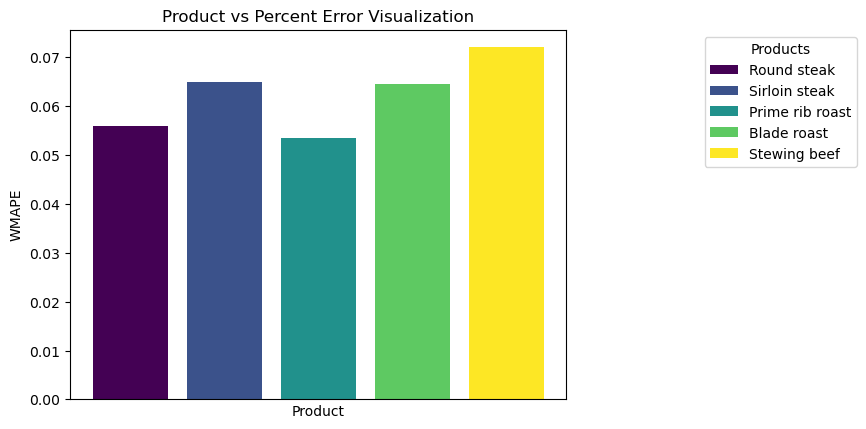

In [16]:
products = wmape_df['product'].unique()
colours = plt.cm.viridis(np.linspace(0, 1, len(products)))
threshold = 0.10 # this represents a threshold error of 10%

fig, ax = plt.subplots()

for i, product in enumerate(products):
    product_data = wmape_df[wmape_df['product'] == product]
    bars = ax.bar(product_data['product'], product_data['wmape'], color=colours[i], label = product)

    for bar, value in zip(bars, product_data['wmape']):
        if value > threshold:
            ax.text(bar.get_x() + bar.get_width() / 2, value, f'{product}\n{value}', ha='center', va='bottom', color='black', fontsize=8)

plt.xlabel('Product')
plt.ylabel('WMAPE')
plt.title('Product vs Percent Error Visualization')
plt.legend(title='Products', bbox_to_anchor=(1.6, 1), loc='upper right')
plt.xticks([]) # Remove category axis labels

plt.show()

In [ ]:
# products = wmape_df['product'].unique()
# colours = plt.cm.viridis(np.linspace(0, 1, len(products)))
# threshold = 0.10 # this represents a threshold error of 10%

# fig, ax = plt.subplots()

# for i, product in enumerate(products):
#     product_data = wmape_df[wmape_df['product'] == product]
#     bars = ax.bar(product_data['product'], product_data['wmape'], color=colours[i], label = product)

#     for bar, value in zip(bars, product_data['wmape']):
#         if value > threshold:
#             ax.text(bar.get_x() + bar.get_width() / 2, value, f'{product}\n{value}', ha='center', va='bottom', color='black', fontsize=8)

# plt.xlabel('Product')
# plt.ylabel('WMAPE')
# plt.title('Product vs Percent Error Visualization')
# plt.legend(title='Products', bbox_to_anchor=(1.6, 1), loc='upper right')
# plt.xticks([]) # Remove category axis labels

# plt.show()

weighted mean absolute percentage error for Round steak: 0.05581860723077433
weighted mean absolute percentage error for Sirloin steak: 0.06496427643862622
weighted mean absolute percentage error for Prime rib roast: 0.053393816500611285
weighted mean absolute percentage error for Blade roast: 0.06457853099537249
weighted mean absolute percentage error for Stewing beef: 0.0719836035898926


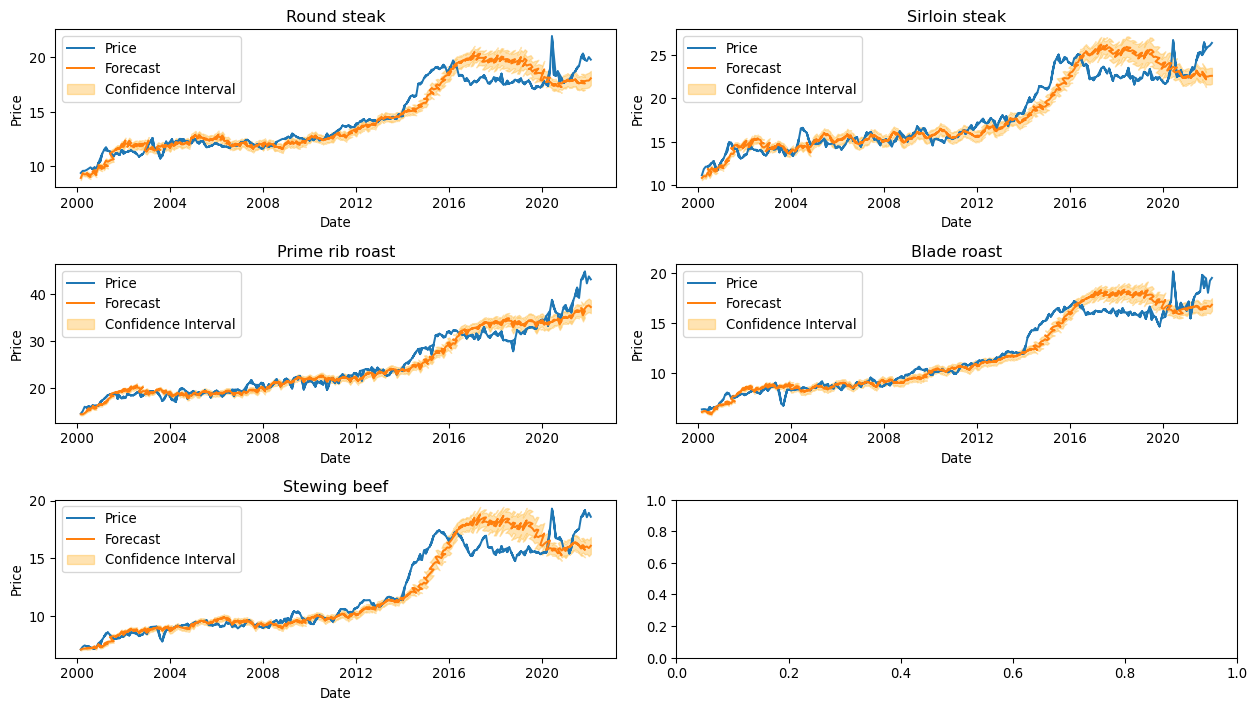

: 

In [17]:
# plot the forecast for the first six items
fig, ax = plt.subplots(3, 2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_, product in enumerate(final['product'].unique()[0:6]):
    p_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

In [ ]:
# plot the forecast for the first six items
fig, ax = plt.subplots(3, 2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_, product in enumerate(final['product'].unique()[0:6]):
    p_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

In [ ]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(final['product'].unique()[6:12]):
    p_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

In [ ]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(final['product'].unique()[12:18]):
    p_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

In [ ]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(final['product'].unique()[18:24]):
    p_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

In [ ]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(final['product'].unique()[24:30]):
    p_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

In [ ]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(final['product'].unique()[30:36]):
    p_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

In [ ]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(final['product'].unique()[36:42]):
    p_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

In [ ]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(final['product'].unique()[42:48]):
    p_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

In [ ]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(final['product'].unique()[48:54]):
    p_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

### Save the models to JSON

In [ ]:
# save the Prophet models as JSON files
from prophet.serialize import model_to_json, model_from_json

...
m.fit(train_)

with open(f'prophet_{product}.json', 'w') as f:
    f.write(model_to_json(m))

future = m.make_future_dataframe(periods = 24, freq= 'M', include_history=False)
...

In [ ]:
# load the model
with open(f'prophet_{product}.json', 'r') as f:
    m = model_from_json(f.read())

### Troubleshooting & Testing

In [ ]:
m.plot_components(forecast)
plt.show()

In [ ]:
forecast['product']

In [ ]:
final = list()

product = 'Peanut butter'

print('product:', product)
# create datasets that contain only the rows from the original training and validation datasets that correspond with the current product being forecasted
train_ = train.loc[train['product'] == product]
valid_ = valid.loc[valid['product'] == product]

# create a Prophet object m with seasonality parameters
m = Prophet(seasonality_mode='additive', yearly_seasonality=True)
# train the model with the product-specific training data
m.fit(train_)

# create a new dataframe that will contain the dates for the next 24 months after the end of the train_ dataset
future = m.make_future_dataframe(periods = 24, freq= 'M', include_history=False)
future

In [ ]:
# create new columns containing only month and year values to permit accurate joins
future['yyyy_mm'] = pd.to_datetime(future['ds']).dt.strftime('%Y-%m')
future

In [ ]:
valid_['yyyy_mm'] = pd.to_datetime(valid_['ds']).dt.strftime('%Y-%m')
valid_

In [ ]:
# drop old 'ds' columns
future.drop(columns=['ds'], inplace=True)
valid_.drop(columns=['ds'], inplace=True)
# rename new 'yyyy_mm' columns to 'ds'
future.rename(columns={'yyyy_mm':'ds'}, inplace=True)
valid_.rename(columns={'yyyy_mm':'ds'}, inplace=True)

In [ ]:
future

In [ ]:
valid_

In [ ]:
# merge future data with valid_ data
future = future.merge(valid_[['ds','product', 'y']], on=['ds'], how='left')

future

In [ ]:
# create a dataframe to contain the predicted values for each date in the {future} dataframe
forecast = m.predict(future)
# add a 'product' column to the forecast dataframe containing predicted values
# this step is essential for distinguishing between predictions, since the final dataframe {p} will contain predictions for all products
forecast['product'] = product
# append the product prediction to the list of stored predictions
final.append(forecast[['ds', 'yhat', 'product']])

In [ ]:
final = pd.concat(final, ignore_index=True)
# clip values in the 'yhat' column to be greater than or equal to 0 so that no negative values are included for the dataset
final['yhat'] = final['yhat'].clip(lower=0)
# create new 'yyyy_mm' column for {valid} dataframe
valid['yyyy_mm'] = pd.to_datetime(valid['ds']).dt.strftime('%Y-%m')
# drop old 'ds' column
valid.drop(columns=['ds'], inplace=True)
# rename new 'yyyy_mm' column to 'ds'
valid.rename(columns={'yyyy_mm':'ds'}, inplace=True)
# convert {valid} 'ds' column to datetime
valid['ds'] = pd.to_datetime(valid['ds'])
# merge prediction {p} dataframe with validation {valid} dataframe to compare values 
final = final.merge(valid, on=['ds', 'product'], how='left')


In [ ]:
final

In [ ]:
print(final.dtypes)

In [ ]:
print(valid.dtypes)

In [ ]:
wmape(final['y'], final['yhat'])